## Serves as a advanced node model which focuses on building model on multiple nodes

### import packages and read data

In [3]:
!pip install /root/git/msspackages/dist/msspackages-0.0.7-py3-none-any.whl
from msspackages import setup_runner
setup_runner(setup_type = 'notebook' , project = 'understanding-eks-data')

Keyring is skipped due to an exception: 'keyring.backends'
Processing /root/git/msspackages/dist/msspackages-0.0.7-py3-none-any.whl
  Using cached pyspark-3.3.1-py2.py3-none-any.whl
  Using cached configparser-5.3.0-py3-none-any.whl (19 kB)
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)
b"Get:1 http://deb.debian.org/debian buster InRelease [122 kB]\nGet:2 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]\nGet:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]\nGet:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [411 kB]\nGet:5 http://deb.debian.org/debian buster/main amd64 Packages [7909 kB]\nGet:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8788 B]\nFetched 8542 kB in 1s (6491 kB/s)\nReading package lists...\nBuilding dependency tree...\nReading state information...\n62 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding depende

In [4]:
%pip install hmmlearn
from msspackages import Pyspark_data_ingestion
from pyspark import StorageLevel
from pyspark.sql.functions import *
from hmmlearn import hmm,base
from sklearn.preprocessing import StandardScaler as scale
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
# pandas settings 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached hmmlearn-0.2.8-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (217 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
%%time
node_obj = Pyspark_data_ingestion(year = '2022', month = "7", day = "7", hour = -1, filter_column_value ='Node',setup='128gb')
spark_node = node_obj.get_spark()
err, node_data = node_obj.read()

CPU times: user 26 ms, sys: 17.9 ms, total: 43.9 ms
Wall time: 11 s


In [5]:
df = node_data.toPandas()

In [6]:
df.InstanceId[:5]

0    i-003af3c608a801ece
1    i-06e7a2de4385b361b
2    i-05c8f02fa0309f1b2
3    i-0c5d6a0a32608913c
4    i-02877760f499ccf02
Name: InstanceId, dtype: object

In [6]:
df = df[df.ClusterName=='nk-ndc-eks-cluster-test-dev-usw2-az2-perf'][['NodeName','Timestamp','node_cpu_utilization','node_memory_utilization']]

In [7]:
def clean_data(df):
    df = df.dropna(subset=['node_cpu_utilization','node_memory_utilization'])
    nodelist = df.NodeName.unique()
    subdfs = []
    for node in nodelist:
        
        subdf = df[df.NodeName==node]
        sc_m = scale()
        sc_c = scale()
        c_s = sc_c.fit_transform(subdf['node_cpu_utilization'].values.reshape(-1,1))
        m_s = sc_m.fit_transform(subdf['node_memory_utilization'].values.reshape(-1,1))
        subdf['node_cpu_utilization'] = c_s
        subdf['node_memory_utilization'] = m_s
        subdfs.append(subdf)
    cleaned = subdfs[0]
    
    for i in subdfs[1:]:
        cleaned = pd.concat([cleaned, i], axis=0)
    return cleaned

In [8]:
import warnings
warnings.filterwarnings('ignore')
new_df = clean_data(df)

## feature selection

In [10]:
len(new_df)

25878

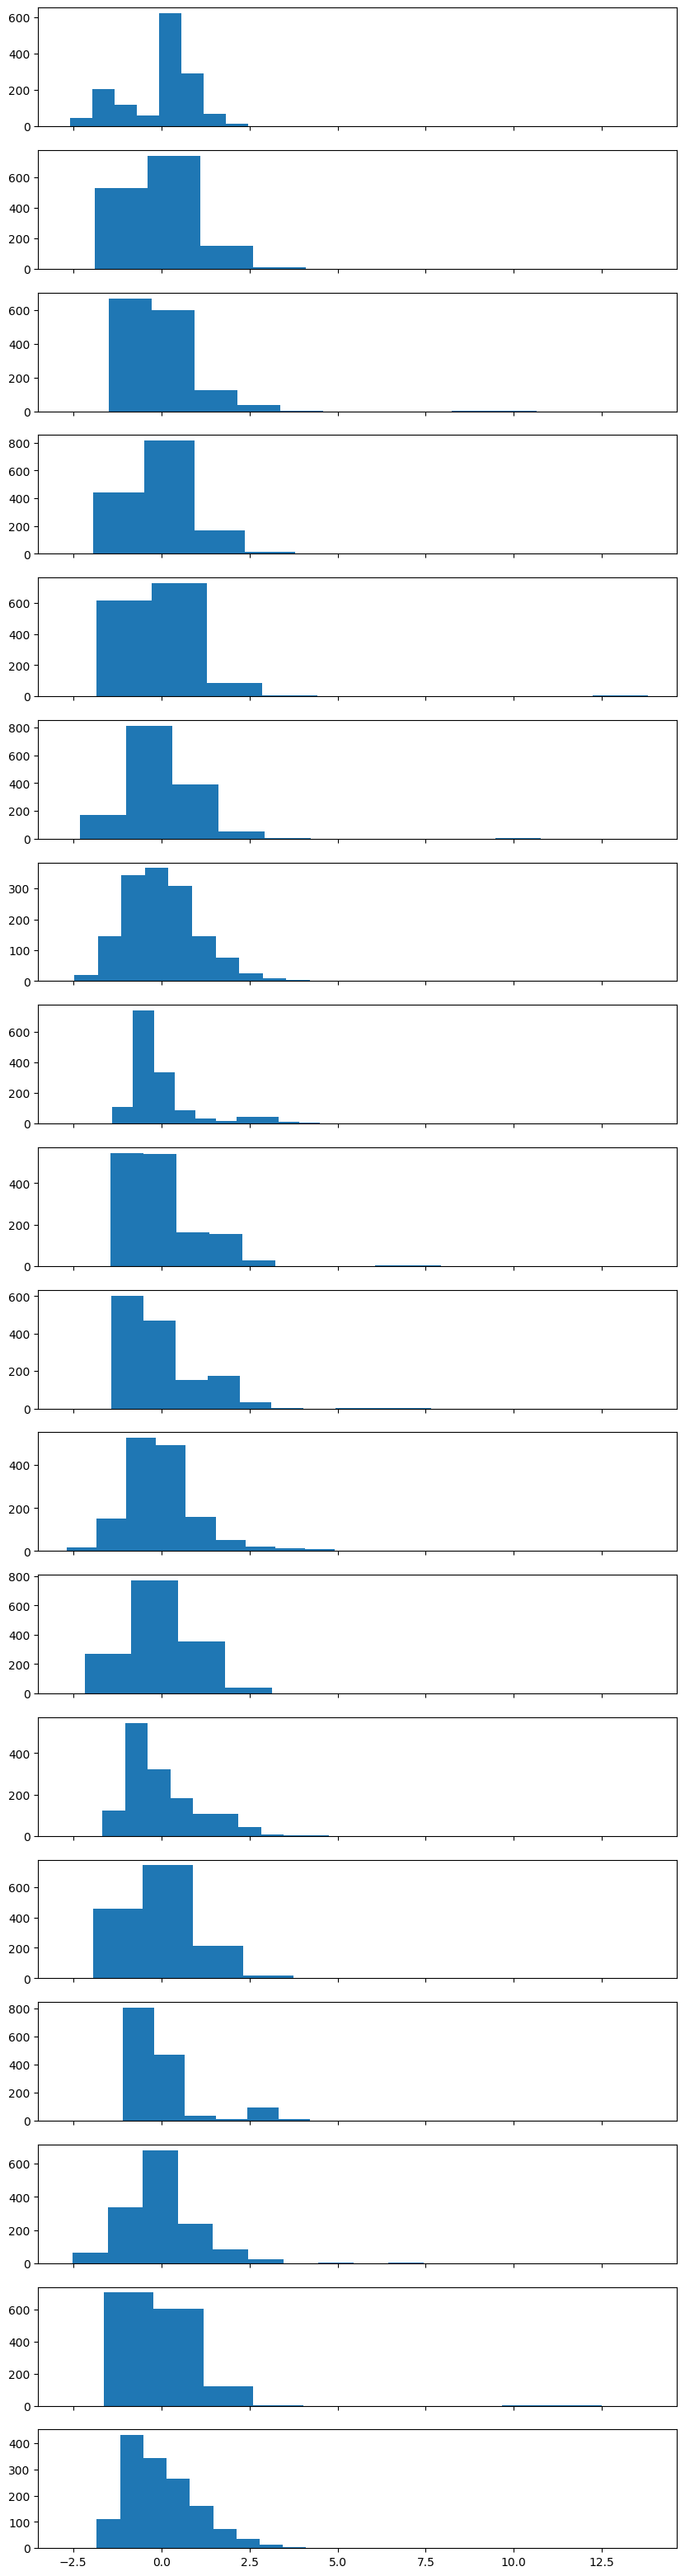

In [53]:
fig,ax = plt.subplots(len(new_df.NodeName.unique()),figsize = (10,40),sharex=True)
i = 0
for node in new_df.NodeName.unique():
    sub = new_df[new_df.NodeName==node]
    ax[i].hist(sub.node_cpu_utilization)
    i+=1
plt.show()
    

In [9]:
new_df.reset_index(inplace=True,drop=True)

In [10]:
new_df.head()

,NodeName,Timestamp,node_cpu_utilization,node_memory_utilization
0,ip-100-64-19-132.us-west-2.compute.internal,1657213330656,0.554079,-0.276946
1,ip-100-64-19-132.us-west-2.compute.internal,1657213389333,0.676859,-0.168000
2,ip-100-64-19-132.us-west-2.compute.internal,1657213451128,0.314578,-0.249959
3,ip-100-64-19-132.us-west-2.compute.internal,1657213512533,0.796408,-0.128520
4,ip-100-64-19-132.us-west-2.compute.internal,1657213574966,0.840753,-0.048559


In [9]:
def sample_data(df,data_frac= 0.5,random_state = 1, slice_length = 6):
    res_ind = df.sample(frac=data_frac/6, replace=True, random_state=random_state).index.to_list()
    for i in res_ind :
        for j in range(slice_length):
            res_ind.append(i+j)
            
    return df.iloc[res_ind.sort()]
        
        
    

In [13]:
res_ind = new_df.sample(frac=0.5/6, replace=True, random_state=1).index.to_list()

In [ ]:

for i in res_ind :
    for j in range(6):
        res_ind.append(i+j)

In [ ]:


res_ind[:5]

In [42]:
new_df.iloc[[5,5]]

,NodeName,Timestamp,node_cpu_utilization,node_memory_utilization
5,ip-100-64-19-132.us-west-2.compute.internal,1657213630459,0.736481,-0.094037
5,ip-100-64-19-132.us-west-2.compute.internal,1657213630459,0.736481,-0.094037


In [12]:
import random
random.choice(range(10))

3

In [5]:
%%time
test = Pyspark_data_ingestion(year = '2022', month = "7", day = "7", hour = "10", filter_column_value ='Node',setup='128gb')
test_node = test.get_spark()
err, test_df = test.read()

CPU times: user 32.6 ms, sys: 16.5 ms, total: 49.1 ms
Wall time: 11.4 s


In [6]:
test_df.show(n=1)

+------------+--------------------+--------------------+--------------------+--------------------+-------------------------------+-------------------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------+--------------------+--------------------+-------------+----+-------+--------------------+--------------+----------------+--------------------------+---------------------+--------------------+-------------------+--------------------+-----------------+-------------------+--------------------------------+-----------------------------------+-----------------+-----------------------+---------------------+-------------------+----------------------+-------------------+-----------------------------+---------------+----------------+-----------------+-----------------------+-----------------------+---------------------+-----------------------+----------------------+----------------

In [7]:
nodelist = test_df.select('NodeName').rdd.flatMap(list).distinct().collect()

In [11]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql import functions as F

In [12]:


#normalize inputdata
features = ['node_cpu_utilization','node_memory_utilization']
w = Window.partitionBy('NodeName')
for c in features:
    test_df = (test_df.withColumn('mean', F.mean(c).over(w))
        .withColumn('stddev', F.stddev(c).over(w))
        .withColumn(c, ((F.col(c) - F.col('mean')) / (F.col('stddev'))))
        .drop('mean')
        .drop('stddev'))
#random select 

In [44]:
random_node_id = random.choice(test_df.select("NodeName").rdd.flatMap(list).collect())
node_fe_df = input_pod_processed_df[(input_pod_processed_df["pod_id"] == random_pod_id)][["Timestamp", "pod_id"] + features].select('*')
        pod_fe_df = pod_fe_df.sort("Timestamp")
        pod_fe_df = pod_fe_df.na.drop(subset=features)

    

-RECORD 0---------------------------------------------------
 account_id                          | 888907375722         
 log_group_name                      | /aws/containerins... 
 log_stream_name                     | ip-10-249-128-122... 
 record_id                           | 49627967500334917... 
 stream_name                         | dp-us-west-2-cont... 
 record_arrival_stream_timestamp     | 2022-07-07 10:01:13  
 record_arrival_stream_epochtime     | 1657188073           
 log_event_timestamp                 | 2022-07-07 10:01:07  
 log_event_epochtime                 | 1657188067000        
 log_event_id                        | 36956528828212494... 
 AutoScalingGroupName                | at-ndc-dsc-asg-de... 
 CloudWatchMetrics                   | [{"Dimensions":[[... 
 ClusterName                         | at-ndc-eks-cluste... 
 InstanceId                          | i-03da0a71b59c14957  
 InstanceType                        | m5.24xlarge          
 NodeName               

In [15]:
import random
random.choice(test_df.select("NodeName").rdd.flatMap(list).collect())

'ip-100-64-30-189.us-west-2.compute.internal'

In [21]:
##pick random node
random_nodename = random.choice(input_df.select("NodeName").rdd.flatMap(list).collect())
node_df = input_df[(input_df["NodeName"] ==  random_nodename)][["Timestamp", "NodeName"] + features].select('*')
node_df = node_df.sort("Timestamp")
node_df = node_df.na.drop(subset=features)

#fix negative number bug 
if node_df.count()-time_steps<= 0:
    print(f'Exception occurred: not enough data')
 


In [27]:
len(nodelist)

863

In [35]:
start = random.choice(range(node_df.count()-time_steps))
node_slice_df = node_df.withColumn('rn', row_number().over(Window.orderBy("Timestamp"))).filter((col("rn") >= start) & (col("rn") < start+time_steps)).select(["Timestamp"] + features)


In [36]:
node_slice_df.show(n=1)

+-------------+--------------------+-----------------------+
|    Timestamp|node_cpu_utilization|node_memory_utilization|
+-------------+--------------------+-----------------------+
|1657190236563|  0.8144852905760385|      0.996398824916613|
+-------------+--------------------+-----------------------+
only showing top 1 row



In [48]:
final_df = np.zeros((1,time_steps,len(features)+1))
#fill the large dataset
final_df[0,:,:,:] = node_slice_df
#add the slice to our df
print(f'Finished with sample #{n}')



IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [51]:
node_slice_df.collect()

AttributeError: 'list' object has no attribute 'to_list'

In [52]:
final_df = np.zeros((1,time_steps,len(features)+1))
final_df[0] = node_slice_df.collect()

In [53]:
final_df[0]

array([[ 1.65719024e+12,  8.14485291e-01,  9.96398825e-01],
       [ 1.65719024e+12, -1.42539877e+00, -9.95925339e-01],
       [ 1.65719029e+12,  8.43483540e-01,  9.96588324e-01],
       [ 1.65719030e+12, -1.55506836e+00, -9.95851585e-01],
       [ 1.65719035e+12, -1.18505889e+00, -9.95612482e-01],
       [ 1.65719036e+12,  7.60353169e-01,  9.96113988e-01],
       [ 1.65719041e+12,  6.32754382e-01,  9.95092341e-01],
       [ 1.65719042e+12, -1.40592620e+00, -9.96044296e-01],
       [ 1.65719048e+12,  6.47457108e-01,  9.95973923e-01],
       [ 1.65719048e+12, -1.28836649e+00, -9.95196133e-01],
       [ 1.65719054e+12,  8.60373222e-01,  9.96278770e-01],
       [ 1.65719054e+12, -1.63757514e+00, -9.95545866e-01]])

In [60]:
n = 0
samplesize = 3
features = ['node_cpu_utilization','node_memory_utilization']
input_df = test_df
time_steps = 12
final_df = np.zeros((samplesize,time_steps,len(features)+1))
while n < samplesize:
    ##pick random node
    random_nodename = random.choice(input_df.select("NodeName").rdd.flatMap(list).collect())
    node_df = input_df[(input_df["NodeName"] ==  random_nodename)][["Timestamp", "NodeName"] + features].select('*')
    node_df = node_df.sort("Timestamp")
    node_df = node_df.na.drop(subset=features)

    #fix negative number bug 
    if node_df.count()-time_steps<= 0:
        print(f'Exception occurred: not enough data')
        continue

    #pick random time slice of 12 timestamps from the random node
    start = random.choice(range(node_df.count()-time_steps))
    node_slice_df = node_df.withColumn('rn', row_number().over(Window.orderBy("Timestamp"))).filter((col("rn") >= start) & (col("rn") < start+time_steps)).select(["Timestamp"] + features)
    
    #fill the large dataset
    final_df[n] = node_slice_df.collect()
    
    print(f'Finished with sample #{n}')

    n += 1

final_df.reshape(time_steps*samplesize,len(features)+1)

Finished with sample #0
Finished with sample #1
Finished with sample #2


array([[ 1.65718885e+12, -5.04600649e-01, -4.03062048e-01],
       [ 1.65718891e+12,  2.83090115e+00, -1.74028145e-01],
       [ 1.65718897e+12, -6.99886627e-02, -1.31919766e+00],
       [ 1.65718903e+12, -1.47811505e-01, -1.35433935e+00],
       [ 1.65718910e+12, -5.32301398e-01, -1.03908572e+00],
       [ 1.65718916e+12, -6.27300954e-01, -9.40198651e-01],
       [ 1.65718921e+12, -4.91434888e-01, -1.08239637e-01],
       [ 1.65718928e+12,  2.05883936e+00,  3.07331245e-01],
       [ 1.65718933e+12, -4.78656325e-02, -3.08669842e-01],
       [ 1.65718939e+12, -3.15578994e-01,  1.59613219e+00],
       [ 1.65718946e+12, -4.78765530e-01, -7.04831071e-01],
       [ 1.65718951e+12, -4.41676893e-01, -4.55570267e-01],
       [ 1.65719065e+12,  6.67141289e+00, -2.65953084e-01],
       [ 1.65719071e+12,  3.13223969e-01, -1.72156672e-01],
       [ 1.65719078e+12, -1.18316788e-01, -7.40986523e-01],
       [ 1.65719083e+12, -6.14298505e-01, -8.40834316e-01],
       [ 1.65719089e+12,  1.07366313e+00

In [61]:
final_df

array([[[ 1.65718885e+12, -5.04600649e-01, -4.03062048e-01],
        [ 1.65718891e+12,  2.83090115e+00, -1.74028145e-01],
        [ 1.65718897e+12, -6.99886627e-02, -1.31919766e+00],
        [ 1.65718903e+12, -1.47811505e-01, -1.35433935e+00],
        [ 1.65718910e+12, -5.32301398e-01, -1.03908572e+00],
        [ 1.65718916e+12, -6.27300954e-01, -9.40198651e-01],
        [ 1.65718921e+12, -4.91434888e-01, -1.08239637e-01],
        [ 1.65718928e+12,  2.05883936e+00,  3.07331245e-01],
        [ 1.65718933e+12, -4.78656325e-02, -3.08669842e-01],
        [ 1.65718939e+12, -3.15578994e-01,  1.59613219e+00],
        [ 1.65718946e+12, -4.78765530e-01, -7.04831071e-01],
        [ 1.65718951e+12, -4.41676893e-01, -4.55570267e-01]],

       [[ 1.65719065e+12,  6.67141289e+00, -2.65953084e-01],
        [ 1.65719071e+12,  3.13223969e-01, -1.72156672e-01],
        [ 1.65719078e+12, -1.18316788e-01, -7.40986523e-01],
        [ 1.65719083e+12, -6.14298505e-01, -8.40834316e-01],
        [ 1.65719089e+